In [6]:
# Note: sometimes repeat unit is e.g. "AAAAA" for something listed as pentamer. not sure if we want to do smoething about that

In [7]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LogNorm
import os
import seaborn as sns
import scipy.stats

import pandas as pd

dfs = []
for chrom in range(1, 23):
    if not os.path.exists("chr%s.period.tab"%chrom): continue
    data = pd.read_csv("chr%s.stats.tab"%chrom, sep="\t")
    dfs.append(data)
data = pd.concat(dfs)

motifs = pd.read_csv("motif_info.tab", sep="\t", names=["chrom", "start","period","motif"])
data = pd.merge(data, motifs, on=["chrom","start"])
data["reflen"] = data.apply(lambda x: (x["end"]-x["start"]+1)/x["period"], 1)
data["reflen-bp"] = data.apply(lambda x: (x["end"]-x["start"]), 1)

data = data[(data["motif"].apply(type)==str)]
data = data[data["chrom"]=="chr1"] # Subset to chr1 to make it faster. trends should be the same


Populating the interactive namespace from numpy and matplotlib


In [8]:
data[(data["period"]==2) & (data["reflen-bp"]==20)]

,chrom,start,end,nalleles-ALL,nalleles-EUR,nalleles-EAS,nalleles-SAS,nalleles-AMR,nalleles-AFR,nalleles-H3A,...,het-EUR,het-EAS,het-SAS,het-AMR,het-AFR,het-H3A,period,motif,reflen,reflen-bp
71,chr1,1029668,1029688,2,3,1,2,2,2,2,...,0.4200,0.13400,0.37300,0.31100,0.58000,0.562,2,AC,10.5,20
86,chr1,1030768,1030788,2,2,2,2,2,2,2,...,0.5020,0.45100,0.49100,0.48100,0.59000,0.636,2,AC,10.5,20
119,chr1,1083444,1083464,1,1,1,1,1,1,1,...,0.0000,0.00000,0.00000,0.00204,0.00670,0.000,2,AG,10.5,20
228,chr1,1283086,1283106,1,1,1,1,1,1,1,...,0.0000,0.00000,0.00832,0.00000,0.00000,0.000,2,AC,10.5,20
676,chr1,1935868,1935888,2,2,2,2,2,3,3,...,0.1670,0.20400,0.26800,0.21700,0.36800,0.356,2,AC,10.5,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148224,chr1,247530166,247530186,1,1,1,1,1,1,1,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.000,2,AT,10.5,20
148280,chr1,247627932,247627952,1,1,1,1,1,1,1,...,0.0000,0.00000,0.00000,0.00000,0.00112,0.000,2,AG,10.5,20
148450,chr1,247967046,247967066,4,4,2,4,4,2,2,...,0.7300,0.54100,0.65200,0.71700,0.48700,0.514,2,AC,10.5,20
148509,chr1,248114210,248114230,3,1,2,1,2,3,3,...,0.0973,0.15700,0.09240,0.15700,0.53500,0.568,2,AT,10.5,20


In [9]:
data[data["motif"]=="AAA"]

,chrom,start,end,nalleles-ALL,nalleles-EUR,nalleles-EAS,nalleles-SAS,nalleles-AMR,nalleles-AFR,nalleles-H3A,...,het-EUR,het-EAS,het-SAS,het-AMR,het-AFR,het-H3A,period,motif,reflen,reflen-bp
113893,chr1,196349673,196349725,1,1,1,1,1,1,1,...,0.00316,0.0203,0.0116,0.00204,0.0111,0.0171,3,AAA,17.666667,52


In [10]:
# Plot reflen vs. het by period, overall and for each population

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int or type(m) == float:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    
def PlotLenVsHet(data, lencol="reflen", pop=None, motifs=None, colors=None, figname=None):
    """
    Plot length vs. het
    If pop=None, use het-ALL. else use het-${pop}
    motifs is a list of motifs. or 1, 2, 3 etc. for
    all motifs with that length. Use "vntr" for 7+
    """
    if lencol == "reflen":
        MINLEN = 10
        MAXLEN = 30
    else:
        MINLEN = 10
        MAXLEN = 100
    if pop is None:
        col = "het-ALL"
    else: col = "het-%s"%pop
    fig = plt.figure()
    fig.set_size_inches((8, 6))
    ax = fig.add_subplot(111)
    if motifs is None:
        motifs = ["ALL"]
        colors = ["black"]
    assert(len(motifs)==len(colors))
    for i in range(len(motifs)):
        m = motifs[i]
        lenbins = range(MINLEN, MAXLEN+1)
        if lencol == "reflen":
            lenbins = np.arange(MINLEN, MAXLEN, 1)
        else:
            if (m in [1,2,3] or (type(m)==str and len(m) <3)) and m != "vntr" and (m != "ALL"):
                lenbins = range(MINLEN, MAXLEN+1)
            else:
                lenbins = np.arange(MINLEN, MAXLEN, 1)  # could go lower resolution here if we want
        color = colors[i]
        xvals = []
        yvals = []
        for j in range(len(lenbins)-1):
            lb = lenbins[j]
            ub = lenbins[j+1]
            xx = data[(data[lencol]>=lb) & (data[lencol]<ub) &
                                      (data["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1))]
            if xx.shape[0] > 10:
                xvals.append(lb)
                yvals.append(np.mean(xx[col]))
        ax.plot(xvals, yvals, color=color, label=m)
    for i in range(MINLEN, MAXLEN+1):
        ax.axvline(x=i, linewidth=0.5, color="gray")
    ax.set_xlabel("Length")
    ax.set_ylabel("Mean heterozygosity")
    ax.legend(loc="lower right")
    ax.set_title(pop)
    if figname is not None: fig.savefig(figname)
        
# Plot reflen vs. het by period, overall and for each population

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int or type(m) == float:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    
def PlotLenVsNum(data, lencol="reflen", motifs=None, colors=None, figname=None):
    """
    Plot length vs. num loci
    motifs is a list of motifs. or 1, 2, 3 etc. for
    all motifs with that length. Use "vntr" for 7+
    """
    if lencol == "reflen":
        MINLEN = 10
        MAXLEN = 30
    else:
        MINLEN = 10
        MAXLEN = 100

    fig = plt.figure()
    fig.set_size_inches((8, 3))
    ax = fig.add_subplot(111)
    if motifs is None:
        motifs = ["ALL"]
        colors = ["black"]
    assert(len(motifs)==len(colors))
    for i in range(len(motifs)):
        m = motifs[i]
        lenbins = range(MINLEN, MAXLEN+1)
        if lencol == "reflen":
            lenbins = np.arange(MINLEN, MAXLEN, 1)
        else:
            if (m in [1,2,3] or (type(m)==str and len(m) <3)) and m != "vntr" and (m != "ALL"):
                lenbins = range(MINLEN, MAXLEN+1)
            else:
                lenbins = np.arange(MINLEN, MAXLEN, 1)  # could go lower resolution here if we want
        color = colors[i]
        xvals = []
        yvals = []
        for j in range(len(lenbins)-1):
            lb = lenbins[j]
            ub = lenbins[j+1]
            xx = data[(data[lencol]>=lb) & (data[lencol]<ub) &
                                      (data["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1))]
            
            if xx.shape[0] > 10:
                xvals.append(lb)
                yvals.append(xx.shape[0])
        ax.plot(xvals, yvals, color=color, label=m)
        ax.set_xlabel("Length")
        ax.set_ylabel("Num loci")
    plt.yscale("log")
    ax.legend(loc="lower right")
    if figname is not None: fig.savefig(figname)

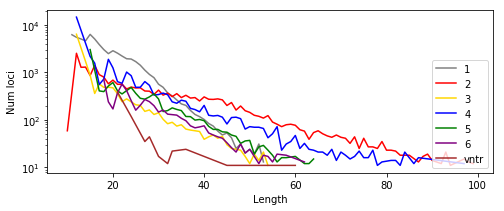

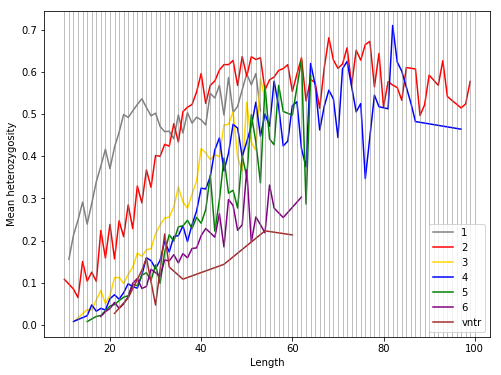

In [11]:
# Overall
PlotLenVsNum(data, motifs=[1,2,3,4,5,6,"vntr"],
             lencol="reflen-bp", colors=["gray","red","gold","blue","green","purple","brown"],
            figname="LengthVsNum-bp-ALL.pdf")
PlotLenVsHet(data, motifs=[1,2,3,4,5,6,"vntr"],
             lencol="reflen-bp", colors=["gray","red","gold","blue","green","purple","brown"],
            figname="LengthVsHet-bp-ALL.pdf");

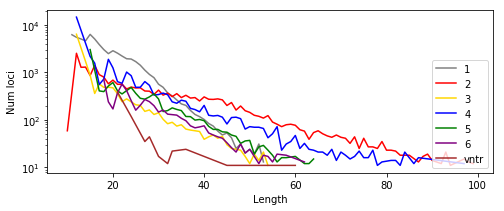

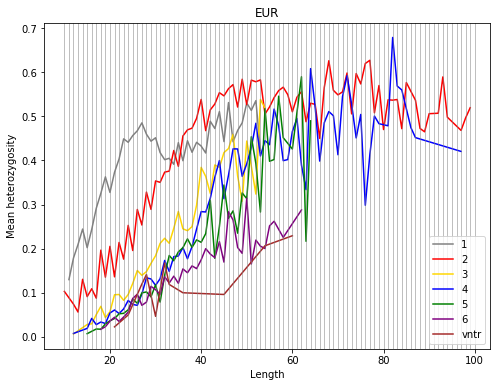

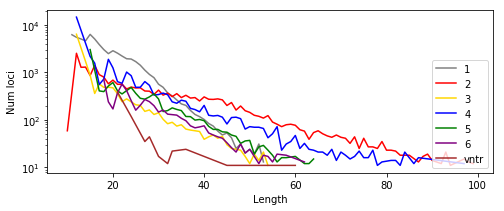

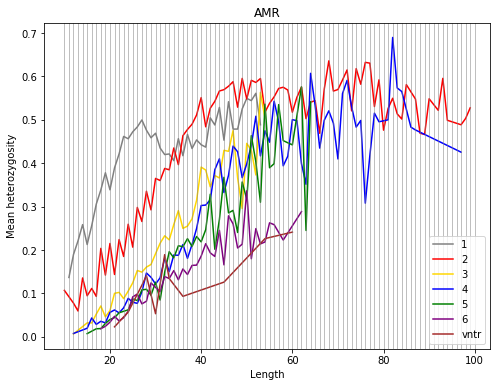

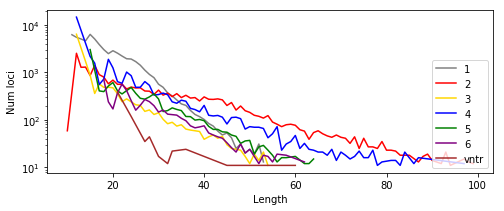

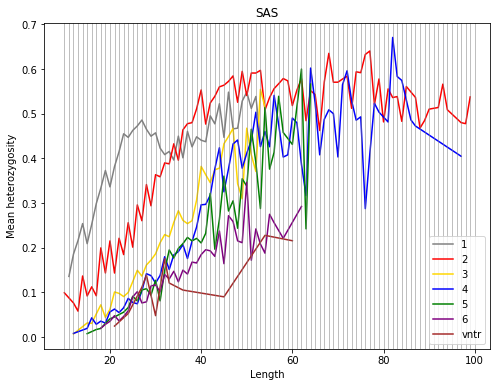

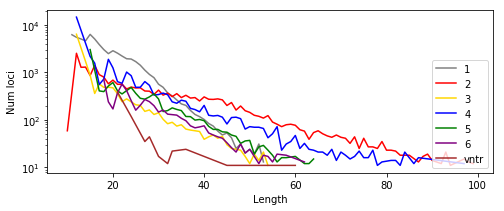

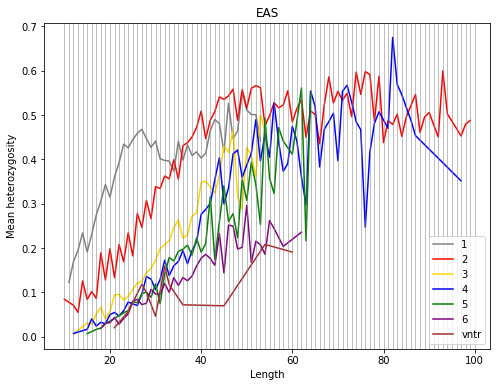

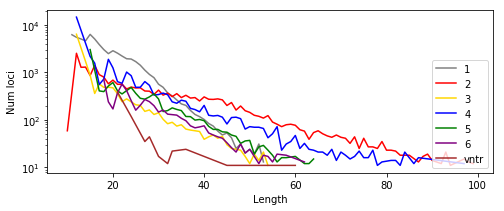

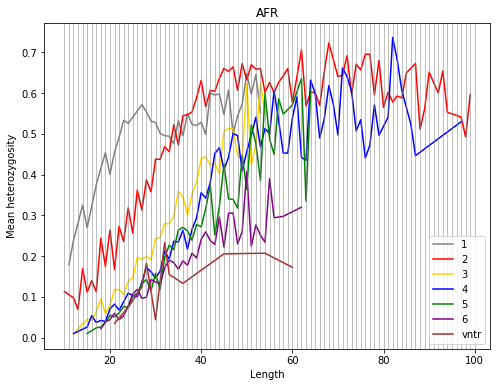

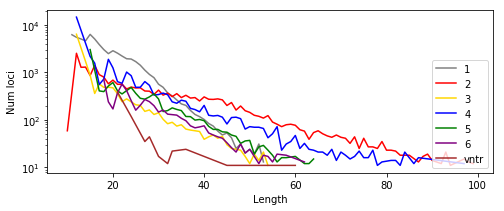

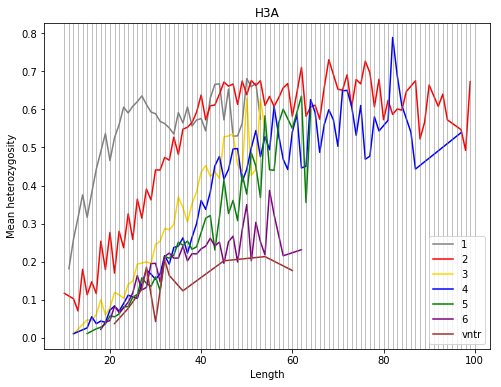

In [12]:
# By population
for pop in ["EUR","AMR","SAS","EAS","AFR","H3A"]:
    PlotLenVsNum(data, motifs=[1,2,3,4,5,6,"vntr"], 
             lencol="reflen-bp", colors=["gray","red","gold","blue","green","purple","brown"],
            figname="LengthVsNum-bp-%s.pdf"%pop);         
    PlotLenVsHet(data, motifs=[1,2,3,4,5,6,"vntr"], pop=pop,
             lencol="reflen-bp", colors=["gray","red","gold","blue","green","purple","brown"],
            figname="LengthVsHet-bp-%s.pdf"%pop);            

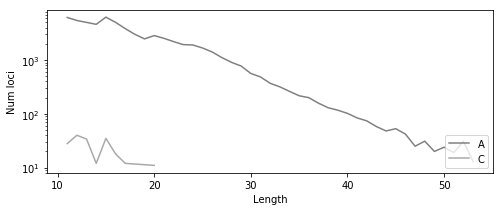

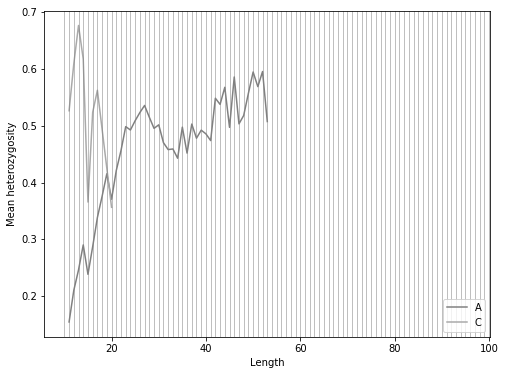

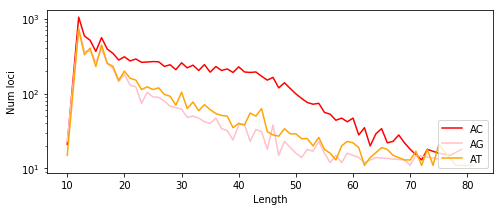

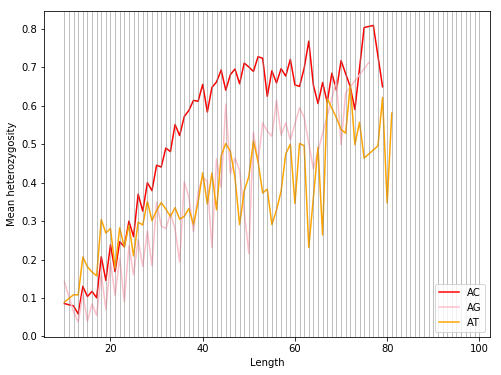

In [13]:
# By motif - for mono/di just plot all of them
PlotLenVsNum(data, motifs=["A","C"], colors=["gray","darkgray"], 
             lencol="reflen-bp", 
            figname="LengthVsNum-bp-Mono.pdf");

PlotLenVsNum(data, motifs=["AC","AG","AT"], colors=["red","pink","orange"], 
             lencol="reflen-bp", 
            figname="LengthVsNum-bp-Dinuc.pdf");
PlotLenVsHet(data, motifs=["AC","AG","AT"], colors=["red","pink","orange"], 
             lencol="reflen-bp", 
            figname="LengthVsHet-bp-Dinuc.pdf");

['AAT', 'AAC', 'AGG', 'AAG', 'AGC', 'ACC', 'ATC', 'CCG', 'ACT', 'ACG']
['AAAT', 'AAAC', 'AAAG', 'AATG', 'AAGG', 'AGGG', 'ACAT', 'AGGC', 'AGAT', 'AATT']
['AAAAC', 'AAAAT', 'AAAAG', 'AAATT', 'AGGGG', 'AAAGG', 'ACCCC', 'AAGGG', 'AATAT', 'AAGAG']
['AAAAAC', 'AAAAAT', 'AAAAAG', 'AAAATT', 'AGAGGG', 'AAAAAA', 'ACATAT', 'AGATAT', 'ACACAT', 'AAATAT']
['AAAAAAC', 'AAAAAAT', 'AAAAAAG', 'AATATAT', 'AAAAAAAG', 'AGCCCCC', 'AAAAATT', 'AGATGAT', 'AGAGGGG', 'AAAAAAAC']


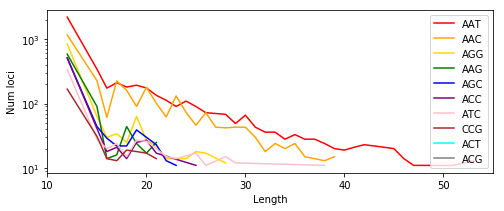

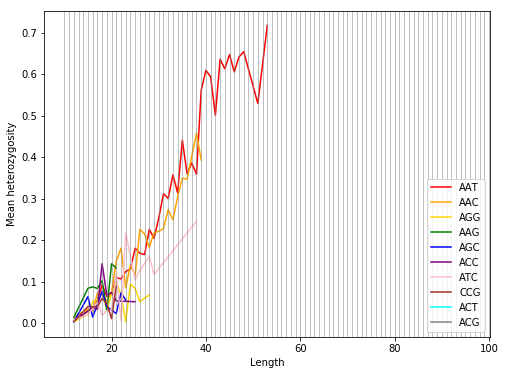

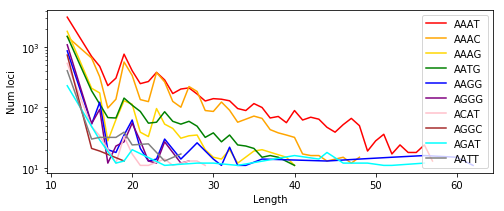

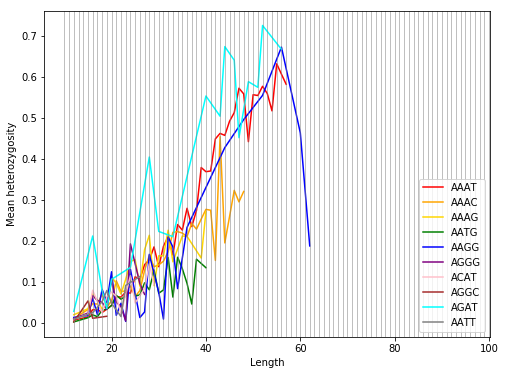

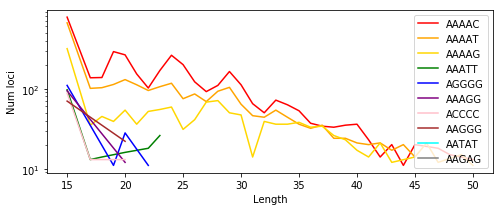

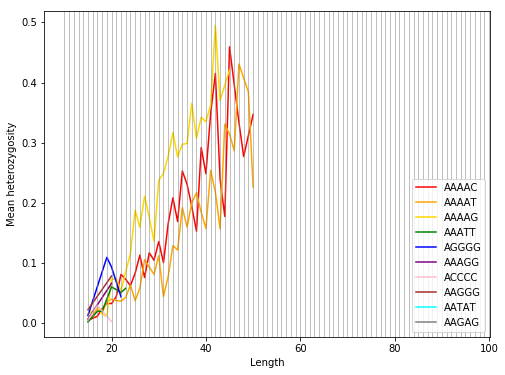

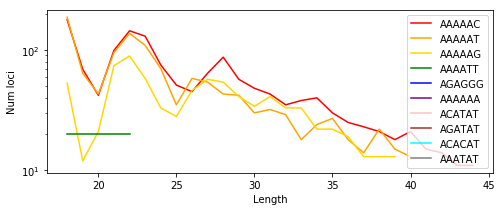

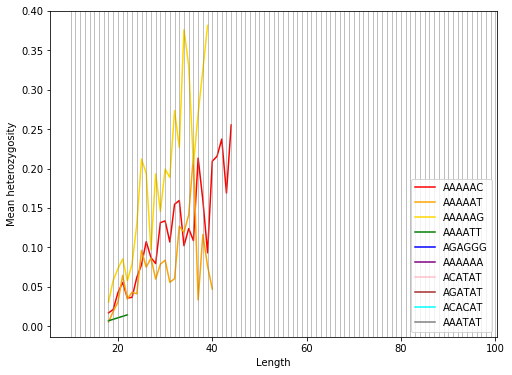

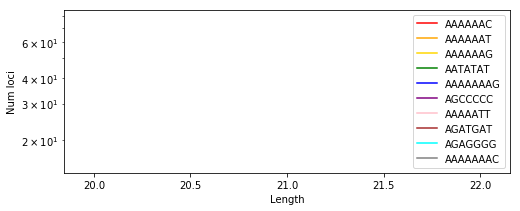

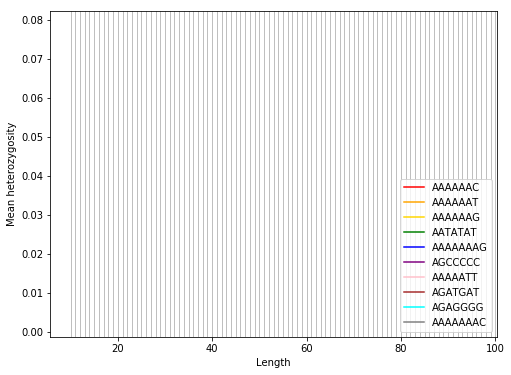

In [14]:
# By motif - for tri + use top motifs
colors = ["red","orange","gold","green","blue","purple","pink","brown","cyan","gray"]
for period in [3,4,5,6,"vntr"]:
    if period == "vntr":
        xx = data[data["period"]>6].groupby("motif", as_index=False).agg({"start": len}).sort_values("start", ascending=False).head(n=10)
    else: 
        xx = data[data["period"]==period].groupby("motif", as_index=False).agg({"start": len}).sort_values("start", ascending=False).head(n=10)
    motifs = list(xx["motif"])
    print(motifs)
    PlotLenVsNum(data, motifs=motifs, colors=colors, 
             lencol="reflen-bp", 
            figname="LengthVsNum-bp-%s.pdf"%period);
    PlotLenVsHet(data, motifs=motifs, colors=colors, 
             lencol="reflen-bp", 
            figname="LengthVsHet-bp-%s.pdf"%period);